I declare that this submission is my own work, and that I did not use any pretrained model or code that I did not explicitly cite.


In [45]:
# import libraries

# general libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# libraries for traing, testing, evaluating model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint



## Data Inspection


In [46]:
# Load data
data = np.load('dataset_dev_3000.npz')

# Explore keys
print("Keys:", data.files)

# Extract arrays
X = data['X']
y = data['y']

print("X shape:", X.shape)
print("y shape:", y.shape)


Keys: ['X', 'y']
X shape: (3000, 32, 32)
y shape: (3000, 3)


In [47]:
# Count number of samples per class
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")


Class 0.0: 387 samples
Class 0.00026430911384522915: 1 samples
Class 0.0012721653329208493: 1 samples
Class 0.001568699604831636: 1 samples
Class 0.001762773492373526: 1 samples
Class 0.0018284324323758483: 1 samples
Class 0.0019072487484663725: 1 samples
Class 0.0020356904715299606: 1 samples
Class 0.0021006499882787466: 1 samples
Class 0.0026393872685730457: 1 samples
Class 0.003119604429230094: 1 samples
Class 0.0033321119844913483: 1 samples
Class 0.0034062291961163282: 1 samples
Class 0.0035183411091566086: 1 samples
Class 0.003814652096480131: 1 samples
Class 0.003852665890008211: 1 samples
Class 0.003922072239220142: 1 samples
Class 0.004057707265019417: 1 samples
Class 0.004159008618444204: 1 samples
Class 0.004307989031076431: 1 samples
Class 0.0043214308097958565: 1 samples
Class 0.0043290406465530396: 1 samples
Class 0.0044805440120399: 1 samples
Class 0.005482145119458437: 1 samples
Class 0.00564561178907752: 1 samples
Class 0.005840257741510868: 1 samples
Class 0.005890033

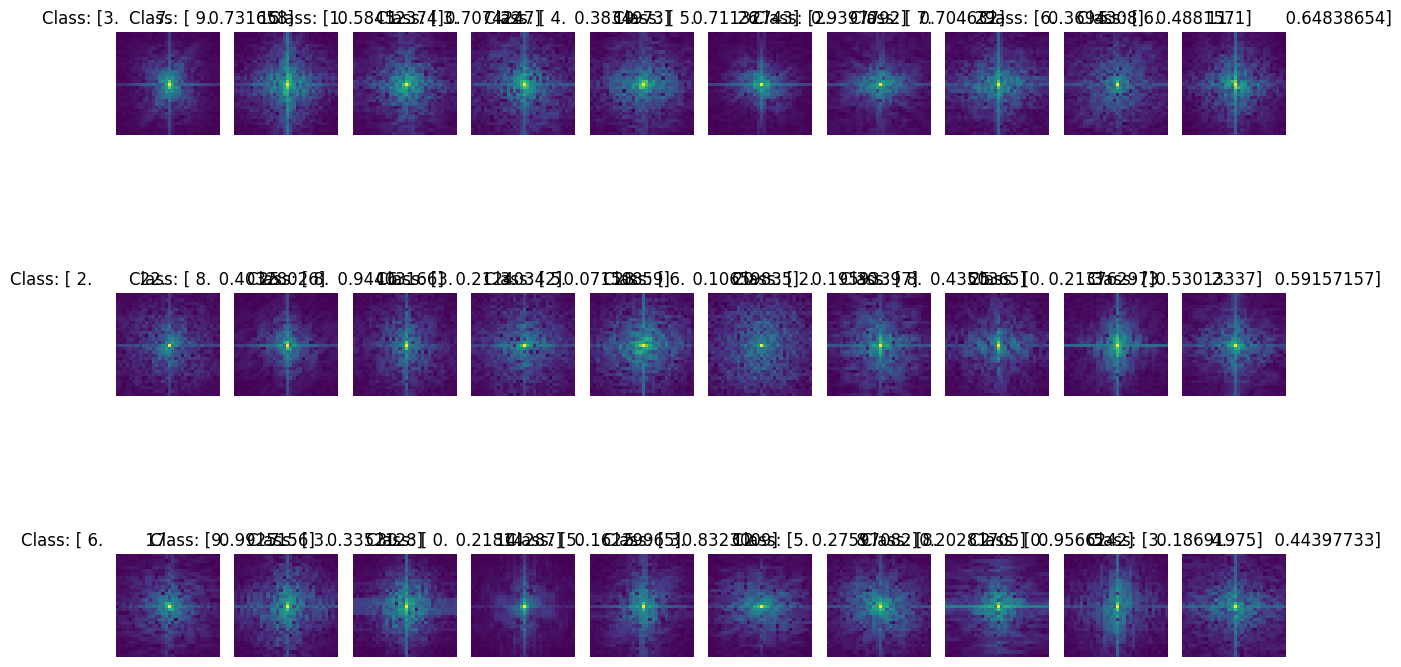

In [48]:
num_images = 30
rows = 3
cols = 10 

plt.figure(figsize=(12, 9))

# Pick 10 random indices
random_indices = np.random.choice(len(X), num_images, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx])
    plt.title(f"Class: {y[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing


In [49]:
# Normalize images
X = X.astype('float32') / 255.0

# Convert (16000, 32, 32) → (16000, 32, 32, 1)
X = X[..., np.newaxis]

y1 = y[:,0]              # Target A (0-9)
y2 = y[:,1]              # Target B (0-31)
y3 = y[:,2].astype('float32')  # Target C (regression)


In [50]:
X.shape

(3000, 32, 32, 1)

In [51]:
# Train test split at 80/20 ratio
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
    X, y[:,0], y[:,1], y[:,2],
    test_size=0.2,
    random_state=42
)
print(X_train.shape, y1_train.shape, y2_train.shape, y3_train.shape)
print(X_test.shape, y1_test.shape, y2_test.shape, y3_test.shape)

(2400, 32, 32, 1) (2400,) (2400,) (2400,)
(600, 32, 32, 1) (600,) (600,) (600,)


## Data Augmentation


In [52]:
X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val = train_test_split(
    X_train, y1_train, y2_train, y3_train, test_size=0.2, random_state=42
)

# Create Dataset from NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, (y1_train, y2_train, y3_train)))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, (y1_val, y2_val, y3_val)))

# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.04),
    layers.RandomZoom(0.1),
])

def augment(x, y):
    x = data_augmentation(x)
    return x, y

train_ds = train_ds.shuffle(1000).map(augment).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

## Architecture


In [53]:
from tensorflow.keras import layers

class LeNet(tf.keras.Model):
    def __init__(self, num_classes=(10,32,1)):
        super(LeNet, self).__init__()

        # Convolutional layers
        self.conv1 = layers.Conv2D(6, kernel_size=5, activation='tanh')
        self.pool1 = layers.AveragePooling2D(pool_size=2, strides=2)

        self.conv2 = layers.Conv2D(16, kernel_size=5, activation='tanh')
        self.pool2 = layers.AveragePooling2D(pool_size=2, strides=2)

        # Fully connected layers
        self.flatten = layers.Flatten()
        
        self.fc1 = layers.Dense(120, activation='tanh')
        self.fc2 = layers.Dense(84, activation='tanh')
        self.output_layer_1 = layers.Dense(num_classes[0], activation='softmax')

        self.fc1_2 = layers.Dense(120, activation='tanh')
        self.fc2_2 = layers.Dense(84, activation='tanh')
        self.output_layer_2 = layers.Dense(num_classes[1], activation='softmax')

        self.fc1_3 = layers.Dense(120, activation='tanh')
        self.fc2_3 = layers.Dense(84, activation='tanh')
        self.output_layer_3 = layers.Dense(num_classes[2], activation='linear')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x_1 = self.fc1(x)
        x_1 = self.fc2(x_1)
        x_1 = self.output_layer_1(x_1)

        x_2 = self.fc1_2(x)
        x_2 = self.fc2_2(x_2)
        x_2 = self.output_layer_2(x_2)

        x_3 = self.fc1_3(x)
        x_3 = self.fc2_3(x_3)
        x_3 = self.output_layer_3(x_3)

        return (x_1, x_2, x_3)




In [54]:
from tensorflow.keras import layers, Model

class AlexNet(Model):
    def __init__(self, input_shape = (32, 32, 1), num_classes=(10,32,1)):
        super(AlexNet, self).__init__()

        # Layer 1
        self.conv1 = layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape)
        self.relu1 = layers.Activation('relu')
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn1 = layers.BatchNormalization()

        # Layer 2
        self.conv2 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu2 = layers.Activation('relu')
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn2 = layers.BatchNormalization()

        # Layer 3
        self.conv3 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu3 = layers.Activation('relu')

        # Layer 4
        self.conv4 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu4 = layers.Activation('relu')

        # Layer 5
        self.conv5 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu5 = layers.Activation('relu')
        self.pool5 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        # Fully connected layers
        self.flatten = layers.Flatten()

        self.fc1_1 = layers.Dense(512)
        self.relu_fc1_1 = layers.Activation('relu')
        self.dropout1_1 = layers.Dropout(0.5)

        self.fc2_1 = layers.Dense(256)
        self.relu_fc2_1 = layers.Activation('relu')
        self.dropout2_1 = layers.Dropout(0.5)

        self.fc1_2 = layers.Dense(512)
        self.relu_fc1_2 = layers.Activation('relu')
        self.dropout1_2 = layers.Dropout(0.5)

        self.fc2_2 = layers.Dense(256)
        self.relu_fc2_2 = layers.Activation('relu')
        self.dropout2_2 = layers.Dropout(0.5)

        self.fc1_3 = layers.Dense(512)
        self.relu_fc1_3 = layers.Activation('relu')
        self.dropout1_3 = layers.Dropout(0.5)

        self.fc2_3 = layers.Dense(256)
        self.relu_fc2_3 = layers.Activation('relu')
        self.dropout2_3 = layers.Dropout(0.5)


        # Output layer
        self.output_layer_1 = layers.Dense(num_classes[0], activation='softmax')
        self.output_layer_2 = layers.Dense(num_classes[1], activation='softmax')
        self.output_layer_3 = layers.Dense(num_classes[2], activation='linear')

    def call(self, x, training=False):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Flatten
        x = self.flatten(x)

        # First path
        x_1 = self.fc1_1(x)
        x_1 = self.relu_fc1_1(x_1)
        x_1 = self.dropout1_1(x_1, training=training)

        x_1 = self.fc2_1(x_1)
        x_1 = self.relu_fc2_1(x_1)
        x_1 = self.dropout2_1(x_1, training=training)
        output_1 = self.output_layer_1(x_1)

        # Second path
        x_2 = self.fc1_2(x)
        x_2 = self.relu_fc1_2(x_2)
        x_2 = self.dropout1_2(x_2, training=training)

        x_2 = self.fc2_2(x_2)
        x_2 = self.relu_fc2_2(x_2)
        x_2 = self.dropout2_2(x_2, training=training)
        output_2 = self.output_layer_2(x_2)

        # Third path
        x_3 = self.fc1_3(x)
        x_3 = self.relu_fc1_3(x_3)
        x_3 = self.dropout1_3(x_3, training=training)

        x_3 = self.fc2_3(x_3)
        x_3 = self.relu_fc2_3(x_3)
        x_3 = self.dropout2_3(x_3, training=training)
        output_3 = self.output_layer_3(x_3)


        # Output
        return (output_1, output_2, output_3)


In [55]:
optimizer = Adam(learning_rate=0.00001) 

model = LeNet()
model.compile(
    optimizer=optimizer,
    loss=[
        'sparse_categorical_crossentropy',
        'sparse_categorical_crossentropy',
        'mse'
    ],
    metrics=[
        ['accuracy'],
        ['accuracy'],
        ['mse']
    ],
    loss_weights=[1.0, 1.0, 0.1] 
)
model.build(input_shape=(None, 32, 32, 1))

c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'le_net_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [56]:
# dummy_input = tf.random.normal((1, 32, 32, 1))
# model(dummy_input)
# model.summary()

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

# # Save the best model based on Target A (first output) validation accuracy
# checkpoint = ModelCheckpoint(
#     filepath='model_s3759957.h5',
#     monitor='val_output_1_accuracy',  # monitor the first output's accuracy
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )


checkpoint = [
    ModelCheckpoint(
        "best_cls10.h5",
        monitor="val_output_1_accuracy",
        mode="max",
        save_best_only=True
    ),
    ModelCheckpoint(
        "best_cls32.h5",
        monitor="val_output_2_accuracy",
        mode="max",
        save_best_only=True
    ),
    ModelCheckpoint(
        "best_reg.h5",
        monitor="val_output_3_mse",
        mode="min",
        save_best_only=True
    )
]


# Training
history = model.fit(
    train_ds,          # tf.data.Dataset for training (X, (y1, y2, y3))
    validation_data=val_ds,  # tf.data.Dataset for validation
    epochs=30,
    verbose=1,
    callbacks=checkpoint
)


Epoch 1/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1067 - accuracy_1: 0.0312 - loss: 5.8008 - mse: 0.3251 - mse_loss: 0.3251 - sparse_categorical_crossentropy_loss: 3.4657

c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_output_1_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):
c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_output_2_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):
c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_output_3_mse available.
  if self._should_save_model(epoch, batch, logs, filepath):


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0995 - accuracy_1: 0.0271 - loss: 5.8001 - mse: 0.3172 - mse_loss: 0.3172 - sparse_categorical_crossentropy_loss: 3.4657 - val_accuracy: 0.0646 - val_accuracy_1: 0.0188 - val_loss: 5.7989 - val_mse: 0.3050 - val_mse_loss: 0.3050 - val_sparse_categorical_crossentropy_loss: 3.4658
Epoch 2/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0820 - accuracy_1: 0.0444 - loss: 5.7989 - mse: 0.3068 - mse_loss: 0.3068 - sparse_categorical_crossentropy_loss: 3.4656

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0870 - accuracy_1: 0.0349 - loss: 5.7975 - mse: 0.2925 - mse_loss: 0.2925 - sparse_categorical_crossentropy_loss: 3.4656 - val_accuracy: 0.0979 - val_accuracy_1: 0.0188 - val_loss: 5.7963 - val_mse: 0.2785 - val_mse_loss: 0.2785 - val_sparse_categorical_crossentropy_loss: 3.4659
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1038 - accuracy_1: 0.0393 - loss: 5.7952 - mse: 0.2727 - mse_loss: 0.2727 - sparse_categorical_crossentropy_loss: 3.4655

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1094 - accuracy_1: 0.0375 - loss: 5.7943 - mse: 0.2617 - mse_loss: 0.2617 - sparse_categorical_crossentropy_loss: 3.4655 - val_accuracy: 0.0979 - val_accuracy_1: 0.0146 - val_loss: 5.7928 - val_mse: 0.2434 - val_mse_loss: 0.2434 - val_sparse_categorical_crossentropy_loss: 3.4660
Epoch 4/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1040 - accuracy_1: 0.0480 - loss: 5.7914 - mse: 0.2365 - mse_loss: 0.2365 - sparse_categorical_crossentropy_loss: 3.4653

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1057 - accuracy_1: 0.0385 - loss: 5.7900 - mse: 0.2209 - mse_loss: 0.2209 - sparse_categorical_crossentropy_loss: 3.4654 - val_accuracy: 0.0979 - val_accuracy_1: 0.0188 - val_loss: 5.7883 - val_mse: 0.1978 - val_mse_loss: 0.1978 - val_sparse_categorical_crossentropy_loss: 3.4662
Epoch 5/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0981 - accuracy_1: 0.0497 - loss: 5.7860 - mse: 0.1851 - mse_loss: 0.1851 - sparse_categorical_crossentropy_loss: 3.4650

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1057 - accuracy_1: 0.0396 - loss: 5.7848 - mse: 0.1711 - mse_loss: 0.1711 - sparse_categorical_crossentropy_loss: 3.4653 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7834 - val_mse: 0.1471 - val_mse_loss: 0.1471 - val_sparse_categorical_crossentropy_loss: 3.4663
Epoch 6/30
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1068 - accuracy_1: 0.0393 - loss: 5.7805 - mse: 0.1301 - mse_loss: 0.1301 - sparse_categorical_crossentropy_loss: 3.4652

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7798 - mse: 0.1238 - mse_loss: 0.1238 - sparse_categorical_crossentropy_loss: 3.4651 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7797 - val_mse: 0.1084 - val_mse_loss: 0.1084 - val_sparse_categorical_crossentropy_loss: 3.4665
Epoch 7/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0984 - accuracy_1: 0.0434 - loss: 5.7767 - mse: 0.0972 - mse_loss: 0.0972 - sparse_categorical_crossentropy_loss: 3.4643

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7767 - mse: 0.0956 - mse_loss: 0.0956 - sparse_categorical_crossentropy_loss: 3.4648 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7782 - val_mse: 0.0924 - val_mse_loss: 0.0924 - val_sparse_categorical_crossentropy_loss: 3.4668
Epoch 8/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1054 - accuracy_1: 0.0428 - loss: 5.7749 - mse: 0.0881 - mse_loss: 0.0881 - sparse_categorical_crossentropy_loss: 3.4643

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7755 - mse: 0.0870 - mse_loss: 0.0870 - sparse_categorical_crossentropy_loss: 3.4646 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7781 - val_mse: 0.0900 - val_mse_loss: 0.0900 - val_sparse_categorical_crossentropy_loss: 3.4670
Epoch 9/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1121 - accuracy_1: 0.0376 - loss: 5.7749 - mse: 0.0847 - mse_loss: 0.0847 - sparse_categorical_crossentropy_loss: 3.4645

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7751 - mse: 0.0858 - mse_loss: 0.0858 - sparse_categorical_crossentropy_loss: 3.4644 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7783 - val_mse: 0.0899 - val_mse_loss: 0.0899 - val_sparse_categorical_crossentropy_loss: 3.4672
Epoch 10/30
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1043 - accuracy_1: 0.0410 - loss: 5.7746 - mse: 0.0833 - mse_loss: 0.0833 - sparse_categorical_crossentropy_loss: 3.4644

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7748 - mse: 0.0858 - mse_loss: 0.0858 - sparse_categorical_crossentropy_loss: 3.4642 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7784 - val_mse: 0.0899 - val_mse_loss: 0.0899 - val_sparse_categorical_crossentropy_loss: 3.4674
Epoch 11/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1082 - accuracy_1: 0.0449 - loss: 5.7738 - mse: 0.0879 - mse_loss: 0.0879 - sparse_categorical_crossentropy_loss: 3.4635

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7746 - mse: 0.0859 - mse_loss: 0.0859 - sparse_categorical_crossentropy_loss: 3.4639 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7785 - val_mse: 0.0898 - val_mse_loss: 0.0898 - val_sparse_categorical_crossentropy_loss: 3.4676
Epoch 12/30
52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1052 - accuracy_1: 0.0460 - loss: 5.7737 - mse: 0.0841 - mse_loss: 0.0841 - sparse_categorical_crossentropy_loss: 3.4630

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7743 - mse: 0.0858 - mse_loss: 0.0858 - sparse_categorical_crossentropy_loss: 3.4638 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7786 - val_mse: 0.0898 - val_mse_loss: 0.0898 - val_sparse_categorical_crossentropy_loss: 3.4678
Epoch 13/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0994 - accuracy_1: 0.0495 - loss: 5.7729 - mse: 0.0865 - mse_loss: 0.0865 - sparse_categorical_crossentropy_loss: 3.4622

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7741 - mse: 0.0858 - mse_loss: 0.0858 - sparse_categorical_crossentropy_loss: 3.4636 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7788 - val_mse: 0.0897 - val_mse_loss: 0.0897 - val_sparse_categorical_crossentropy_loss: 3.4680
Epoch 14/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1079 - accuracy_1: 0.0354 - loss: 5.7734 - mse: 0.0849 - mse_loss: 0.0849 - sparse_categorical_crossentropy_loss: 3.4630

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1057 - accuracy_1: 0.0375 - loss: 5.7739 - mse: 0.0856 - mse_loss: 0.0856 - sparse_categorical_crossentropy_loss: 3.4634 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7790 - val_mse: 0.0897 - val_mse_loss: 0.0897 - val_sparse_categorical_crossentropy_loss: 3.4682
Epoch 15/30
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1000 - accuracy_1: 0.0359 - loss: 5.7739 - mse: 0.0849 - mse_loss: 0.0849 - sparse_categorical_crossentropy_loss: 3.4637

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1057 - accuracy_1: 0.0391 - loss: 5.7737 - mse: 0.0855 - mse_loss: 0.0855 - sparse_categorical_crossentropy_loss: 3.4633 - val_accuracy: 0.0979 - val_accuracy_1: 0.0146 - val_loss: 5.7791 - val_mse: 0.0896 - val_mse_loss: 0.0896 - val_sparse_categorical_crossentropy_loss: 3.4684
Epoch 16/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1063 - accuracy_1: 0.0363 - loss: 5.7733 - mse: 0.0826 - mse_loss: 0.0826 - sparse_categorical_crossentropy_loss: 3.4629

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1057 - accuracy_1: 0.0349 - loss: 5.7734 - mse: 0.0855 - mse_loss: 0.0855 - sparse_categorical_crossentropy_loss: 3.4631 - val_accuracy: 0.0979 - val_accuracy_1: 0.0229 - val_loss: 5.7793 - val_mse: 0.0895 - val_mse_loss: 0.0895 - val_sparse_categorical_crossentropy_loss: 3.4686
Epoch 17/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1077 - accuracy_1: 0.0435 - loss: 5.7721 - mse: 0.0870 - mse_loss: 0.0870 - sparse_categorical_crossentropy_loss: 3.4616

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1094 - accuracy_1: 0.0385 - loss: 5.7732 - mse: 0.0854 - mse_loss: 0.0854 - sparse_categorical_crossentropy_loss: 3.4629 - val_accuracy: 0.0958 - val_accuracy_1: 0.0146 - val_loss: 5.7795 - val_mse: 0.0895 - val_mse_loss: 0.0895 - val_sparse_categorical_crossentropy_loss: 3.4689
Epoch 18/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1050 - accuracy_1: 0.0382 - loss: 5.7730 - mse: 0.0818 - mse_loss: 0.0818 - sparse_categorical_crossentropy_loss: 3.4627

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1063 - accuracy_1: 0.0365 - loss: 5.7730 - mse: 0.0853 - mse_loss: 0.0853 - sparse_categorical_crossentropy_loss: 3.4627 - val_accuracy: 0.0979 - val_accuracy_1: 0.0167 - val_loss: 5.7798 - val_mse: 0.0894 - val_mse_loss: 0.0894 - val_sparse_categorical_crossentropy_loss: 3.4691
Epoch 19/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1081 - accuracy_1: 0.0279 - loss: 5.7723 - mse: 0.0840 - mse_loss: 0.0840 - sparse_categorical_crossentropy_loss: 3.4619

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1068 - accuracy_1: 0.0339 - loss: 5.7728 - mse: 0.0852 - mse_loss: 0.0852 - sparse_categorical_crossentropy_loss: 3.4626 - val_accuracy: 0.0958 - val_accuracy_1: 0.0250 - val_loss: 5.7800 - val_mse: 0.0894 - val_mse_loss: 0.0894 - val_sparse_categorical_crossentropy_loss: 3.4694
Epoch 20/30
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1078 - accuracy_1: 0.0400 - loss: 5.7711 - mse: 0.0853 - mse_loss: 0.0853 - sparse_categorical_crossentropy_loss: 3.4604

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1109 - accuracy_1: 0.0359 - loss: 5.7726 - mse: 0.0852 - mse_loss: 0.0852 - sparse_categorical_crossentropy_loss: 3.4624 - val_accuracy: 0.1000 - val_accuracy_1: 0.0146 - val_loss: 5.7802 - val_mse: 0.0893 - val_mse_loss: 0.0893 - val_sparse_categorical_crossentropy_loss: 3.4697
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1217 - accuracy_1: 0.0389 - loss: 5.7719 - mse: 0.0863 - mse_loss: 0.0863 - sparse_categorical_crossentropy_loss: 3.4613

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1286 - accuracy_1: 0.0359 - loss: 5.7723 - mse: 0.0850 - mse_loss: 0.0850 - sparse_categorical_crossentropy_loss: 3.4622 - val_accuracy: 0.1125 - val_accuracy_1: 0.0167 - val_loss: 5.7804 - val_mse: 0.0893 - val_mse_loss: 0.0893 - val_sparse_categorical_crossentropy_loss: 3.4699
Epoch 22/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1192 - accuracy_1: 0.0406 - loss: 5.7724 - mse: 0.0832 - mse_loss: 0.0832 - sparse_categorical_crossentropy_loss: 3.4613

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1125 - accuracy_1: 0.0365 - loss: 5.7722 - mse: 0.0851 - mse_loss: 0.0851 - sparse_categorical_crossentropy_loss: 3.4621 - val_accuracy: 0.1021 - val_accuracy_1: 0.0167 - val_loss: 5.7807 - val_mse: 0.0893 - val_mse_loss: 0.0893 - val_sparse_categorical_crossentropy_loss: 3.4702
Epoch 23/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1325 - accuracy_1: 0.0409 - loss: 5.7698 - mse: 0.0860 - mse_loss: 0.0860 - sparse_categorical_crossentropy_loss: 3.4596

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1214 - accuracy_1: 0.0349 - loss: 5.7720 - mse: 0.0850 - mse_loss: 0.0850 - sparse_categorical_crossentropy_loss: 3.4620 - val_accuracy: 0.1125 - val_accuracy_1: 0.0146 - val_loss: 5.7811 - val_mse: 0.0891 - val_mse_loss: 0.0891 - val_sparse_categorical_crossentropy_loss: 3.4706
Epoch 24/30
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1246 - accuracy_1: 0.0309 - loss: 5.7722 - mse: 0.0861 - mse_loss: 0.0861 - sparse_categorical_crossentropy_loss: 3.4615

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1120 - accuracy_1: 0.0344 - loss: 5.7718 - mse: 0.0850 - mse_loss: 0.0850 - sparse_categorical_crossentropy_loss: 3.4618 - val_accuracy: 0.1167 - val_accuracy_1: 0.0250 - val_loss: 5.7813 - val_mse: 0.0891 - val_mse_loss: 0.0891 - val_sparse_categorical_crossentropy_loss: 3.4708
Epoch 25/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1134 - accuracy_1: 0.0358 - loss: 5.7715 - mse: 0.0856 - mse_loss: 0.0856 - sparse_categorical_crossentropy_loss: 3.4597

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1240 - accuracy_1: 0.0385 - loss: 5.7716 - mse: 0.0849 - mse_loss: 0.0849 - sparse_categorical_crossentropy_loss: 3.4616 - val_accuracy: 0.1417 - val_accuracy_1: 0.0271 - val_loss: 5.7816 - val_mse: 0.0890 - val_mse_loss: 0.0890 - val_sparse_categorical_crossentropy_loss: 3.4711
Epoch 26/30
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1089 - accuracy_1: 0.0394 - loss: 5.7704 - mse: 0.0832 - mse_loss: 0.0832 - sparse_categorical_crossentropy_loss: 3.4603

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1073 - accuracy_1: 0.0365 - loss: 5.7714 - mse: 0.0848 - mse_loss: 0.0848 - sparse_categorical_crossentropy_loss: 3.4615 - val_accuracy: 0.1104 - val_accuracy_1: 0.0229 - val_loss: 5.7818 - val_mse: 0.0890 - val_mse_loss: 0.0890 - val_sparse_categorical_crossentropy_loss: 3.4714
Epoch 27/30
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1062 - accuracy_1: 0.0431 - loss: 5.7707 - mse: 0.0856 - mse_loss: 0.0856 - sparse_categorical_crossentropy_loss: 3.4597

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1115 - accuracy_1: 0.0411 - loss: 5.7713 - mse: 0.0849 - mse_loss: 0.0849 - sparse_categorical_crossentropy_loss: 3.4613 - val_accuracy: 0.1104 - val_accuracy_1: 0.0271 - val_loss: 5.7820 - val_mse: 0.0890 - val_mse_loss: 0.0890 - val_sparse_categorical_crossentropy_loss: 3.4716
Epoch 28/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1039 - accuracy_1: 0.0454 - loss: 5.7697 - mse: 0.0837 - mse_loss: 0.0837 - sparse_categorical_crossentropy_loss: 3.4596

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1198 - accuracy_1: 0.0406 - loss: 5.7712 - mse: 0.0848 - mse_loss: 0.0848 - sparse_categorical_crossentropy_loss: 3.4612 - val_accuracy: 0.1208 - val_accuracy_1: 0.0271 - val_loss: 5.7824 - val_mse: 0.0889 - val_mse_loss: 0.0889 - val_sparse_categorical_crossentropy_loss: 3.4720
Epoch 29/30
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1171 - accuracy_1: 0.0396 - loss: 5.7689 - mse: 0.0872 - mse_loss: 0.0872 - sparse_categorical_crossentropy_loss: 3.4596

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1089 - accuracy_1: 0.0401 - loss: 5.7710 - mse: 0.0848 - mse_loss: 0.0848 - sparse_categorical_crossentropy_loss: 3.4611 - val_accuracy: 0.1167 - val_accuracy_1: 0.0271 - val_loss: 5.7827 - val_mse: 0.0889 - val_mse_loss: 0.0889 - val_sparse_categorical_crossentropy_loss: 3.4723
Epoch 30/30
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1088 - accuracy_1: 0.0437 - loss: 5.7685 - mse: 0.0863 - mse_loss: 0.0863 - sparse_categorical_crossentropy_loss: 3.4584

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1089 - accuracy_1: 0.0406 - loss: 5.7709 - mse: 0.0847 - mse_loss: 0.0847 - sparse_categorical_crossentropy_loss: 3.4610 - val_accuracy: 0.1104 - val_accuracy_1: 0.0271 - val_loss: 5.7830 - val_mse: 0.0888 - val_mse_loss: 0.0888 - val_sparse_categorical_crossentropy_loss: 3.4726
